In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import skmob
import osmnx as ox
import mobair

# Taxicabs dataset: taxis' trajectories in Rome

We will use data on taxis' trajectories in Rome, Italy, that are freely available at https://crawdad.org/roma/taxi/20140717/.

The original dataset contains GPS coordinates of approximately 320 taxis collected over 30 days (during February 2014). We will load a subset of 1 million rows to speed up computations.

In [4]:
import pandas as pd

df = pd.read_csv('data/public/taxi_february_sample_1mln.zip', compression='zip', parse_dates=['datetime'])

###
def get_lat(row):
    lat, lng = row.split('POINT(')[1].split(')')[0].split(' ')
    return lat

def get_lng(row):
    lat, lng = row.split('POINT(')[1].split(')')[0].split(' ')
    return lng
###

df['lat'] = df['point'].apply(lambda x: get_lat(x))
df['lng'] = df['point'].apply(lambda x: get_lng(x))
tdf = skmob.TrajDataFrame(df.drop('point', axis=1))

print('Num. of points: ', tdf.shape[0])
print('Num. of vehicles: ', len(set(tdf.uid)))
print('Time interval: ', max(tdf['datetime'])-min(tdf['datetime']))
print('')
print(tdf.head())

Num. of points:  1000000
Num. of vehicles:  290
Time interval:  2 days 22:35:27.068101

   uid                         datetime        lat        lng
0  187 2014-02-01 00:00:01.148457+01:00  41.928543  12.469037
1  297 2014-02-01 00:00:01.220066+01:00  41.891069  12.492705
2   89 2014-02-01 00:00:01.470854+01:00  41.793177  12.432122
3   79 2014-02-01 00:00:01.631136+01:00  41.900275  12.462746
4  191 2014-02-01 00:00:02.048546+01:00  41.852305  12.577407


### Trajectory selection

Now, we select only the trajectories of the vehicles moving inside the chosen region, which will be the center of Rome (a bounding box enclosing the Grande Raccordo Anulare).

In order to do it, we will use `scikit-mobility` to download a __tessellation__ over the region of interest, then map each point to its corresponding cell, and finally discarding points that fall outside the tessellation.

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from shapely.geometry import Polygon
import geopandas as gpd
from skmob.utils import plot

# - create a Polygon (in our case, a squared bounding box) defining the region of interest:
w, s, e, n = 12.3700189905,41.7921454931,12.6194086892,41.992920201 #12.4245386292,41.8504801359,12.5528040226,41.9449307469
region_city_center = Polygon([[w, s],[e, s],[e, n],[w, n]])

# - create a GeoDataFrame with the region's Polygon as geometry:
REGION = gpd.GeoDataFrame([['city center', region_city_center]], columns=['region_name', 'geometry'])
REGION.crs = 'epsg:4326'  # defining the CRS

map_f = plot.plot_gdf(REGION, zoom=11, 
                      style_func_args={'color': 'gray', 'fillColor': 'gray', 'opacity': 0.25})
map_f

In [6]:
# define the name of the region:
#REGION = 'Rome, Italy'

## Now we can download the tessellation over the chosen region, after setting the desired size of its cells...
cell_size = 1000  # the side of each cell in the tessellation (in meters)

from skmob.tessellation import tilers
tessellation = tilers.tiler.get("squared", base_shape=REGION, meters=cell_size)

## ... and then select the trajectories within the tessellation:
from mobair.utils import select_trajectories_within_tessellation

tdf_mapped = select_trajectories_within_tessellation(tdf, tessellation)

print('Num. of points inside the region: ', tdf_mapped.shape[0])
print('Num. of vehicles: ', len(set(tdf_mapped.uid)))

Num. of points inside the region:  300354
Num. of vehicles:  108


In [7]:
from skmob.utils import plot

map_f = plot.plot_gdf(tessellation, zoom=11, 
                      style_func_args={'color': 'gray', 'fillColor': 'gray', 'opacity': 0.25})
map_f = tdf_mapped.plot_trajectory(map_f=map_f, start_end_markers=False, max_points=1000)
map_f

# Preprocessing

### Noise filtering
A straightforward way of identifying and filtering out outliers is to compute the instantaneous speed of the user in each of the points composing its trajectory, and filter out those points whose value of speed is unreliable (e.g. speed > 300 $km/h$).

In [8]:
from skmob.preprocessing import filtering

ftdf = filtering.filter(tdf_mapped, max_speed_kmh=300)

print('%s points removed.' %(len(tdf)-len(ftdf)))

701407 points removed.


### Compression
We can spatially __cluster__ the points that are closer than, e.g., 50 meters from each other, in order to reduce the number of points forming the trajectories. This can be particularly useful for the next step, usually named _stop detection_.

In [9]:
from skmob.preprocessing import compression

# compress the trajectory using a spatial radius of 50m
ctdf = compression.compress(ftdf, spatial_radius_km=0.05)

### Stops detection

Identifying the __stop locations__ (or _stay points_) in an important step in trajectory data mining, as it let us make some useful things like:
- _trajectory segmentation_, which consists in splitting the trajectories into sub-trajectories, thus identifying the different trips made by each user during the period;
- identification of the _semantic locations_, like Points-of-Interest, most frequented locations (in our case, the taxi stand, or the airport), etc.

We can identify the stop locations of each vehicle as the points where it spent at least `t` minutes within a certain radius `r` from it.

In the following example, `t = 10 minutes` and `r = 200 meters`.

In [10]:
from skmob.preprocessing import detection

stdf = detection.stops(ctdf, minutes_for_a_stop=10.0, spatial_radius_km=0.2, leaving_time=True)
print('Num. of stops: ', stdf.shape[0])
print(stdf.head())

Num. of stops:  1257
  uid                         datetime        lat        lng tile_ID  \
0   4 2014-02-03 14:34:58.612889+01:00  41.902155  12.480766     388   
1   4 2014-02-03 15:31:14.330132+01:00  41.902015  12.480545     388   
2   4 2014-02-03 16:16:20.524076+01:00  41.901757  12.480768     388   
3   4 2014-02-03 16:51:22.887651+01:00  41.910564  12.498480     451   
4   4 2014-02-03 18:36:21.255161+01:00  41.902007  12.481318     388   

                  leaving_datetime  
0 2014-02-03 15:12:28.191324+01:00  
1 2014-02-03 15:44:28.235045+01:00  
2 2014-02-03 16:37:28.440353+01:00  
3 2014-02-03 17:18:15.372050+01:00  
4 2014-02-03 18:50:09.982018+01:00  


### Trajectory segmentation

We can use the identifyied stop locations of each vehicle to group the points into different sub-trajectories identifying trips occurring between different stop locations. 

In our case, each of these sub-trajectories will (hopefully) represent a single ride made by the taxi (with or without a passenger).

In [11]:
from mobair.utils import split_trajectories_in_tdf

tdf_splitted = split_trajectories_in_tdf(ctdf, stdf)
print(tdf_splitted.head())

  uid                         datetime        lat        lng tile_ID  tid
0   4 2014-02-03 13:14:41.121329+01:00  41.921721  12.418604     174    1
1   4 2014-02-03 13:15:17.296149+01:00  41.922489  12.419163     174    1
2   4 2014-02-03 13:15:32.655035+01:00  41.923617  12.419324     174    1
3   4 2014-02-03 13:15:46.661238+01:00  41.924661  12.419323     174    1
4   4 2014-02-03 13:16:04.766601+01:00  41.925160  12.419234     174    1


### Time filtering
An important last step of our preprocessing is a filtering of the trajectories in which we retain a trajectory only if:
- it is composed by at least 2 points,
- the distance between two consecutive points is not greater than a threshold (that we call ```max_interval``` here).

This is an important step because the densest the trajectories are, the more reliable the estimates of speed and acceleration and, by consequence, those of emissions, will be.

In [12]:
from mobair import filtering

max_interval = 120  # max time (in seconds) between two consecutive points of a trajectory

tdf_filtered_time = filtering.filter_on_time_interval(tdf_splitted, max_interval)

In [33]:
def print_stats(tdf):
    print('>> stats <<')
    num_of_uid = len(set(tdf['uid']))
    print('> Number of users: %s' % num_of_uid)
    map__uid__n_traj = {uid : len(traj) for uid,traj in tdf.groupby('uid').tid.unique().to_dict().items()}
    num_of_traj = sum(map__uid__n_traj.values())
    print('> Number of trajectories: %s' % num_of_traj)
    print('> Number of points: %s' % len(tdf))
    map__uid__n_traj = {uid : len(traj) for uid, traj in tdf.groupby('uid').tid.unique().to_dict().items()}
    print('> Avg num traj per vehicle: ', np.mean(list(map__uid__n_traj.values())))
    print('> Std num traj per vehicle: ', np.std(list(map__uid__n_traj.values())))
    map__uid_tid__n_points = {(uid,tid): n_points for ((uid,tid),n_points) in tdf.groupby(['uid','tid']).datetime.count().to_dict().items()}
    print('> Avg num points per traj: ', np.mean(list(map__uid_tid__n_points.values())))
    print('> Std num points per traj: ', np.std(list(map__uid_tid__n_points.values())))
    df_time_diffs = pd.DataFrame(tdf.groupby(['uid', 'tid']).datetime.diff())
    print('> Avg sampling rate: ', df_time_diffs.astype('timedelta64[s]').mean()[0])
    print('> Std sampling rate: ', df_time_diffs.astype('timedelta64[s]').std()[0])
    print("")
    return
####

print_stats(tdf_filtered_time)

>> stats <<
> Number of users: 106
> Number of trajectories: 2492
> Number of points: 99687
> Avg num traj per vehicle:  23.50943396226415
> Std num traj per vehicle:  14.53963047661743
> Avg num points per traj:  40.002808988764045
> Std num points per traj:  35.27142507897231
> Avg sampling rate:  22.005000257214878
> Std sampling rate:  17.01220212651607



# Speed and acceleration computation

Here we compute the instantaneous speed and acceleration of the vehicle in each point of its trajectories, and filter out points in which we obtain unreliable values.

In [13]:
from mobair import speed

max_speed = 300
max_acc = 10

tdf_with_speed_and_acc = speed.compute_acceleration_from_tdf(tdf_filtered_time)

ftdf = tdf_with_speed_and_acc[(tdf_with_speed_and_acc['acceleration'] < max_acc) &
                              (tdf_with_speed_and_acc['acceleration'] > -max_acc) &
                              (tdf_with_speed_and_acc['speed'] < max_speed)]
print(ftdf.head())

   uid                         datetime        lat        lng tile_ID  tid  \
0    4 2014-02-03 13:14:41.121329+01:00  41.921721  12.418604     174    1   
1    4 2014-02-03 13:15:17.296149+01:00  41.922489  12.419163     174    1   
2    4 2014-02-03 13:15:32.655035+01:00  41.923617  12.419324     174    1   
3    4 2014-02-03 13:15:46.661238+01:00  41.924661  12.419323     174    1   
4    4 2014-02-03 13:16:04.766601+01:00  41.925160  12.419234     174    1   

      speed  acceleration  
0  0.000000      0.000000  
1  2.684746      0.074216  
2  8.208240      0.359629  
3  8.287508      0.005659  
4  3.091781     -0.286972  


# Matching with the road network

We place the points onto the road network in order to assign to each road the emissions it hosted during the period.

### 1. loading the road network
We use ```osmnx``` here to load the road network of the city center of Rome.

In [14]:
import osmnx as ox

# define the neighbourhood
region_name = 'Rome, Italy'

# loading the network
#road_network = ox.graph_from_place(region_name, network_type='drive_service')
#w, s, e, n = 12.4245386292,41.8504801359,12.5528040226,41.9449307469
#road_network = ox.graph_from_bbox(n, s, e, w, network_type='drive_service')
road_network = ox.graph_from_polygon(region_city_center, network_type='drive_service')

# the network type may be one of: 
# - 'drive' : get drivable public streets (but not service roads)
# - 'drive_service' : get drivable public streets, including service roads
# - 'walk' : get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
# - 'bike' : get all streets and paths that cyclists can use
# - 'all' : download all (non-private) OSM streets and paths
# - 'all_private' : download all OSM streets and paths, including private-access ones

# saving the num. of edges
num_edges_dir = len(road_network.edges)

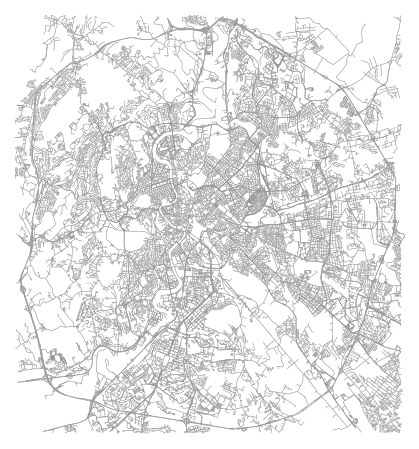

In [39]:
fig, ax = ox.plot_graph(road_network, bgcolor='white', node_size=0, edge_linewidth=0.6)

In [15]:
road_network = ox.get_undirected(road_network)

num_edges_undir = len(road_network.edges)
print('Num. of edges of the directed multigraph:', num_edges_dir)
print('Num. of edges of the undirected multigraph:', num_edges_undir)

Num. of edges of the directed multigraph: 86368
Num. of edges of the undirected multigraph: 58780


### 2. Points snapping

Finally, we simply assign each point in our ```TrajdataFrame``` to its nearest edge (i.e. street) of the road network.

In [16]:
from mobair import mapmatching

tdf_final = mapmatching.find_nearest_edges_in_network(road_network, tdf_mapped, return_tdf_with_new_col=True)
print(tdf_final.head())

    uid                         datetime        lat        lng tile_ID  \
6   341 2014-02-01 00:00:02.709888+01:00  41.910213  12.477000     358   
8    59 2014-02-01 00:00:03.707117+01:00  41.896783  12.482199     387   
11  351 2014-02-01 00:00:04.487352+01:00  41.910051  12.496609     451   
17  188 2014-02-01 00:00:06.830676+01:00  41.921932  12.490790     422   
19  352 2014-02-01 00:00:07.040664+01:00  41.897833  12.469395     356   

                     road_link  
6   (259655876, 1558346622, 0)  
8    (25419073, 1421279862, 0)  
11  (247701954, 5383138464, 0)  
17  (259291955, 1363447880, 0)  
19    (25388200, 301351626, 0)  


# Emissions' estimation

Our emissions' estimation step only needs the information on each vehicle's engine type (whether it is a "PETROL", "DIESEL", or "LPG" vehicle), and some emissions functions.

In this example, as we do not have the information about the real vehicles' engines, we arbitrarily set 75\% random taxis to be petrol vehicles, 20\% diesel, and 5\% LPG (Liquid Petroleum Gas).

In [17]:
## create the dictionary indicating the engine type for each vehicle
import numpy as np

set_uids = set(tdf_final.uid)
map__vehicle__fuel_type = {uid : np.random.choice(['PETROL', 'DIESEL', 'LPG'], 1, p=[0.75, 0.2, 0.05]).item() for uid in set_uids}

In [18]:
## loading the emissions functions
import pandas as pd

df_emissions = pd.read_csv('./data/public/emission_functions.csv')

In [24]:
## computing emissions
from mobair import emissions

tdf_with_emissions = emissions.compute_emissions(tdf_final, df_emissions, map__vehicle__fuel_type)
print(tdf_with_emissions.head())

estimating VOC...
estimating CO_2...
estimating PM...
estimating NO_x...
    uid                         datetime        lat        lng tile_ID  \
6   341 2014-02-01 00:00:02.709888+01:00  41.910213  12.477000     358   
8    59 2014-02-01 00:00:03.707117+01:00  41.896783  12.482199     387   
11  351 2014-02-01 00:00:04.487352+01:00  41.910051  12.496609     451   
17  188 2014-02-01 00:00:06.830676+01:00  41.921932  12.490790     422   
19  352 2014-02-01 00:00:07.040664+01:00  41.897833  12.469395     356   

                     road_link  speed  acceleration      VOC   CO_2   PM  \
6   (259655876, 1558346622, 0)    0.0           0.0  0.00447  0.553  0.0   
8    (25419073, 1421279862, 0)    0.0           0.0  0.00447  0.553  0.0   
11  (247701954, 5383138464, 0)    0.0           0.0  0.00447  0.553  0.0   
17  (259291955, 1363447880, 0)    0.0           0.0  0.00447  0.553  0.0   
19    (25388200, 301351626, 0)    0.0           0.0  0.00447  0.553  0.0   

        NO_x  
6   0.0006

## Visualising emissions onto the roads

We can use here ```Altair``` to plot the road network with each road colored with respect to the emissions it suffers.

In [28]:
import altair as alt
from altair_saver import save
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [29]:
df_emissions_per_road = tdf_with_emissions.groupby('road_link')['CO_2'].sum()

map__road__emissions = df_emissions_per_road.to_dict()

In [30]:
from mobair.utils import add_edge_emissions

road_network = add_edge_emissions(map__road__emissions, road_network, name_of_pollutant='CO_2')

In [ ]:
from mobair import plot

chart = plot.streetDraw(region_name, road_network, 'CO_2', normalize_by_length=True,
                        show_legend=False, schemeColor='yelloworangered', size=(600,600), save_fig=False)
chart


<img align="left" width="600" height="600" src="rome_taxi_emissions.png">

As can be seen from the map, the movements of the taxis concentrate in the city center. This fact will reflect on the shape of the emissions' distributions across the roads, as we will see in the next section.

## Emissions' distributions
And finally we can visualize and fit the distributions of the estimated emissions across the vehicles and roads. 

We use here the `powerlaw` library for computing the Complementary Cumulative Distribution Function (CCDF) of the emissions of each pollutant (CO$_2$, NO$_x$, PM, VOC) across the vehicles (left) and roads (right) of the chosen district, and show these distributions on a log-log plot.

Then, we use methods built upon the same library for fitting.

In [25]:
from mobair import emissions
import numpy as np

def aggregate_emissions(tdf, dist_type):
    if dist_type == 'vehicle':
        # mapping emissions per vehicle:
        map__vehicle__CO2 = emissions.map_vehicle_to_emissions(tdf, 'CO_2')
        map__vehicle__cum_CO2 = {uid: np.sum(em) for uid, em in map__vehicle__CO2.items()}
        map__vehicle__NOx = emissions.map_vehicle_to_emissions(tdf, 'NO_x')
        map__vehicle__cum_NOx = {uid: np.sum(em) for uid, em in map__vehicle__NOx.items()}
        map__vehicle__PM = emissions.map_vehicle_to_emissions(tdf, 'PM')
        map__vehicle__cum_PM = {uid: np.sum(em) for uid, em in map__vehicle__PM.items()}
        map__vehicle__VOC = emissions.map_vehicle_to_emissions(tdf, 'VOC')
        map__vehicle__cum_VOC = {uid: np.sum(em) for uid, em in map__vehicle__VOC.items()}

        map__vehicle__cum_all = {
            uid: [map__vehicle__cum_CO2[uid], map__vehicle__cum_NOx[uid], map__vehicle__cum_PM[uid],
                  map__vehicle__cum_VOC[uid]] for uid in map__vehicle__cum_CO2}
        df_cum_em = pd.DataFrame.from_dict(map__vehicle__cum_all, orient='index',
                                           columns=['CO_2', 'NO_x', 'PM', 'VOC']).reset_index().rename(
            columns={'index': 'uid'}, inplace=False)

    elif dist_type == 'road':
        # mapping emissions per road:
        map__road__CO2 = emissions.map_road_to_emissions(tdf, 'CO_2')
        map__road__cum_CO2 = {uid: np.sum(em) for uid, em in map__road__CO2.items()}
        map__road__NOx = emissions.map_road_to_emissions(tdf, 'NO_x')
        map__road__cum_NOx = {uid: np.sum(em) for uid, em in map__road__NOx.items()}
        map__road__PM = emissions.map_road_to_emissions(tdf, 'PM')
        map__road__cum_PM = {uid: np.sum(em) for uid, em in map__road__PM.items()}
        map__road__VOC = emissions.map_road_to_emissions(tdf, 'VOC')
        map__road__cum_VOC = {uid: np.sum(em) for uid, em in map__road__VOC.items()}

        map__road__cum_all = {
            uid: [map__road__cum_CO2[uid], map__road__cum_NOx[uid], map__road__cum_PM[uid], map__road__cum_VOC[uid]] for
            uid in map__road__cum_CO2}
        df_cum_em = pd.DataFrame.from_dict(map__road__cum_all, orient='index',
                                           columns=['CO_2', 'NO_x', 'PM', 'VOC']).reset_index().rename(
            columns={'index': 'road_link'}, inplace=False)

    else:
        print("dist_type must be in {'vehicle', 'road'}")
        return

    return df_cum_em

### CCDF

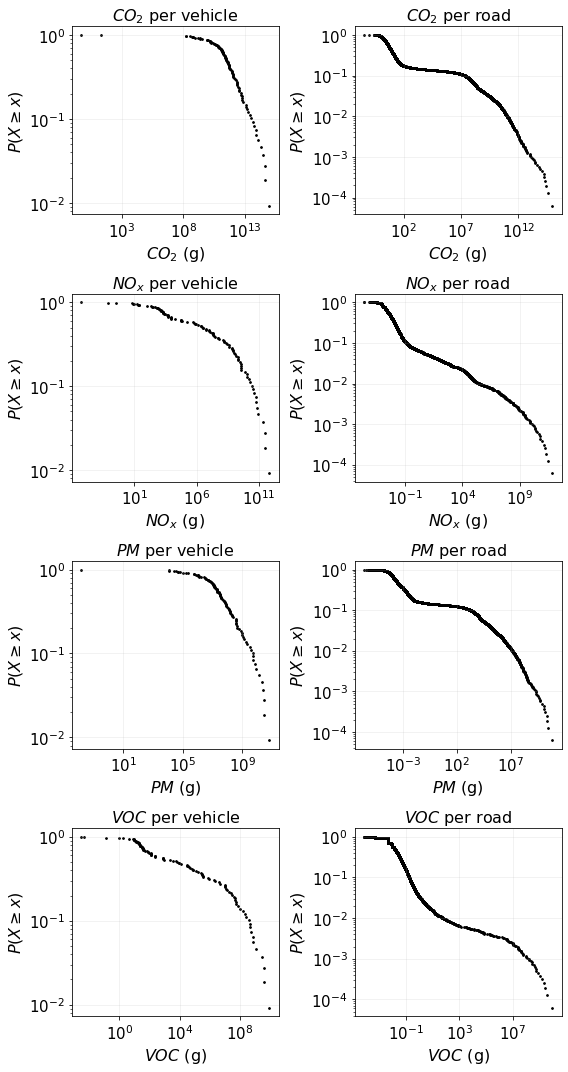

In [26]:
import matplotlib.pyplot as plt
from powerlaw import ccdf

list__tuple_dist_pollutant = [
    ('vehicles', 'CO_2'), ('roads', 'CO_2'),
    ('vehicles', 'NO_x'), ('roads', 'NO_x'), 
    ('vehicles', 'PM'), ('roads', 'PM'), 
    ('vehicles', 'VOC'), ('roads', 'VOC'), 
]


fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(8, 15))

for ax, (c_dist, c_pollutant) in zip(axs.flat, list__tuple_dist_pollutant):
    
    # loading df
    df = aggregate_emissions(tdf_with_emissions, c_dist[:-1])
    
    # tacking the column with the current pollutant
    list_cumulate_emissions = list(df[c_pollutant])
    
    # using powerlaw package to compute the CCDF of the current distribution
    x, y = ccdf(list_cumulate_emissions, linear_bins=False)
    
    # plotting
    ax.scatter(x, y, color='black', s=3, label='data')
    ax.set_xlabel(r'$%s$ (g)' %c_pollutant, fontsize=16)
    ax.set_ylabel(r'$P(X \geq x)$', fontsize=16)
    ax.tick_params(axis='x', which='minor', bottom=True)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(r'$%s$ per %s' %(c_pollutant, c_dist[:-1]), fontsize=16)
    ax.grid(alpha=0.2)

plt.tight_layout()
plt.show()

### Fitting
The methods are collected in ```fitting.py```, and can are used here to fit and plot _one single_ distribution (i.e. of one type - per vehicle/road -, for one pollutant) per run.

-- Fitting distribution vehicle --
num points :  108
fixed xmin:  False
Best fit(s) :  ['truncated_power_law']
-- end --


Assuming nested distributions
Assuming nested distributions


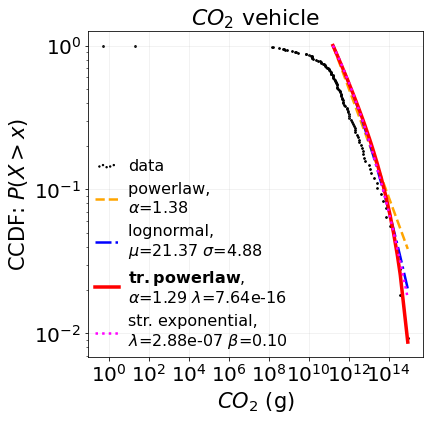

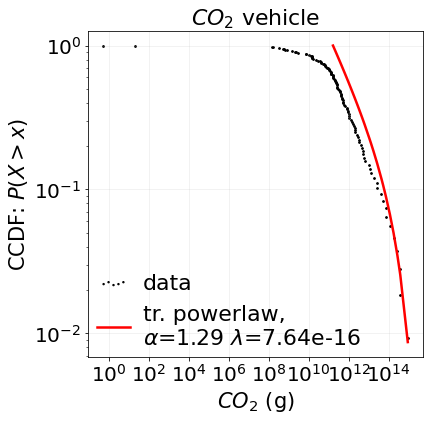

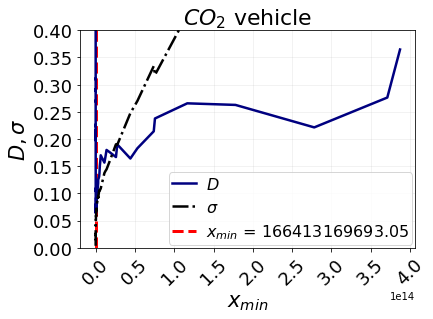

In [27]:
from fitting import *


dist_type = 'vehicle'  # one of {"vehicle", "road"}
pollutant = 'CO_2'     # one of {CO_2, NO_x, PM, VOC}


####
df = aggregate_emissions(tdf_with_emissions, dist_type)

map__dist_type__distribution = {
    dist_type : list(df[pollutant]),
}

map__dist_type__fitting_results, map__dist_type__comparison_results = fit_powerlaw(map__dist_type__distribution,
                                                                                   'Xicheng District, Beijing',
                                                                                   pollutant, xmin=None,
                                                                                   sigma_threshold=0.05,
                                                                                   list_distributions_to_fit=[
                                                                                       'power_law', 'lognormal',
                                                                                       'exponential',
                                                                                       'truncated_power_law',
                                                                                       'stretched_exponential'],
                                                                                   plot_ccdf=True,
                                                                                   plot_pdf=False,
                                                                                   plot_xmin=True,
                                                                                   x_label=r'$%s$ (g)' %pollutant, 
                                                                                   single_fit_to_plot='truncated_power_law', 
                                                                                   save_figures=False)